In [1]:
import pandas as pd
import numpy as np
import datetime 

In [2]:
import statsmodels.formula.api as smf
import os
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as pxy
import plotly.graph_objects as go
# from sklearn.metrics import r2_score, mean_squared_error
# import sklearn.metrics
# from sklearn.metrics import confusion_matrix, accuracy_score
# from sklearn.model_selection import train_test_split

# from scipy.stats import shapiro

In [3]:
pd.set_option('display.max_rows', 1000)
pd.options.display.max_columns = 1000

# "Let's get the mop?!" Data imports and cleaning

In [4]:
# dict_df['HubSpot Customer Base Metadata'].info()
# Cannot use xlrd package to read excel file because a critical number of rows are deleted. Expected 250k+, only received 65k+ 

In [51]:
hcm = pd.read_csv('C:/Users/shant/GNIZE/Study/HubSpot_Customer_Base_Metadata.csv', header=0)
hcv = pd.read_csv('C:/Users/shant/GNIZE/Study/HubSpot_Customer_Base_Value.csv', header=0) 
ie = pd.read_csv('C:/Users/shant/GNIZE/Study/Integration_Ecosystem.csv', header=0)

removing duplicates

In [52]:
hcm = hcm.drop_duplicates()
hcv = hcv.drop_duplicates()
ie = ie.drop_duplicates()

checking for null values

In [53]:
hcm.info()
#only dataset with null values. Product Tier contains customers with Undefined and null values. 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 274125 entries, 0 to 274126
Data columns (total 6 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Customer ID             274125 non-null  int64 
 1   Report Month            274125 non-null  object
 2   Customer Employee Size  274125 non-null  object
 3   Product Tier            262462 non-null  object
 4   Customer Segment        274125 non-null  object
 5   Number of Integrations  274125 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 14.6+ MB


In [54]:
hcm.replace(np.NaN, 'Undefined', inplace=True)
#filling null values with Undefined. To be addressed after joining tables below

In [55]:
hcv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 273984 entries, 0 to 274126
Data columns (total 5 columns):
 #   Column                             Non-Null Count   Dtype 
---  ------                             --------------   ----- 
 0   Customer ID                        273984 non-null  int64 
 1   Report Month                       273984 non-null  object
 2   Customer Value Beginning of Month  273984 non-null  object
 3   Customer Value End of Month        273984 non-null  object
 4   Customer Cancellation Dollars      273984 non-null  object
dtypes: int64(1), object(4)
memory usage: 12.5+ MB


In [56]:
ie.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32746 entries, 0 to 32745
Data columns (total 9 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   Integration ID                            32746 non-null  int64 
 1   Report Month                              32746 non-null  object
 2   Integration Connect Partner? (Yes/No)     32746 non-null  object
 3   Paid Portal Installed Count               32746 non-null  int64 
 4   Free Portal Installed Count               32746 non-null  int64 
 5   Total Installed Count                     32746 non-null  int64 
 6   Integration Total MRR Beginning of Month  32746 non-null  object
 7   Integration Total MRR End of Month        32746 non-null  object
 8   Integration Total Cancellation Dollars    32746 non-null  object
dtypes: int64(4), object(5)
memory usage: 2.5+ MB


changing datatypes 

In [57]:
# hcm['Customer_ID'] = hcm['Customer_ID'].astype(str)
hcm['Report Month'] = pd.to_datetime(hcm['Report Month'], format='%Y-%m').dt.to_period('m')
hcv['Report Month'] = pd.to_datetime(hcv['Report Month'], format='%Y-%m').dt.to_period('m')
ie['Report Month'] = pd.to_datetime(ie['Report Month'], format='%Y-%m').dt.to_period('m')

In [58]:
def remove_dollar_and_commas_and_convert_to_float(value):
    if isinstance(value, str) and any(char.isdigit() for char in value):
        # Remove dollar sign and commas and convert to float
        value_cleaned = value.replace('$', '').replace(',', '')
        return float(value_cleaned)
    elif isinstance(value, (int, float)):
        return float(value)
    else:
        return value

In [59]:
hcv = hcv.applymap(remove_dollar_and_commas_and_convert_to_float)
ie = ie.applymap(remove_dollar_and_commas_and_convert_to_float)

new columns for anaysis

In [60]:
ie['Integration Total MRR Increase'] = ie['Integration Total MRR End of Month'].subtract(ie['Integration Total MRR Beginning of Month'])

In [61]:
check= ie[ie['Integration Total MRR Increase'] < 0]

In [62]:
check

,Integration ID,Report Month,Integration Connect Partner? (Yes/No),Paid Portal Installed Count,Free Portal Installed Count,Total Installed Count,Integration Total MRR Beginning of Month,Integration Total MRR End of Month,Integration Total Cancellation Dollars,Integration Total MRR Increase
104,105.0,2019-01,Yes,26.0,8.0,34.0,38092.0,37816.0,0.0,-276.0
117,118.0,2019-01,Yes,1882.0,943.0,2825.0,2824724.0,2812074.0,-42117.0,-12650.0
147,148.0,2019-01,No,1.0,1.0,2.0,900.0,875.0,0.0,-25.0
195,196.0,2019-01,No,2.0,0.0,2.0,9803.0,9556.0,0.0,-247.0
233,234.0,2019-01,No,81.0,29.0,110.0,164620.0,157350.0,-4964.0,-7270.0
...,...,...,...,...,...,...,...,...,...,...
32680,3400.0,2018-08,No,1.0,0.0,1.0,350.0,263.0,0.0,-87.0
32712,2201.0,2018-08,Yes,281.0,40.0,321.0,424663.0,422127.0,-100.0,-2536.0
32713,1954.0,2018-08,Yes,34.0,2.0,36.0,55586.0,54680.0,0.0,-906.0
32730,3019.0,2018-08,No,1.0,0.0,1.0,299.0,279.0,0.0,-20.0


In [115]:
#to add column with first month integrations count
for customer_id, group in hcm.groupby('Customer ID'):
    min_report_month = group['Report Month'].min()
    min_integrations = group.loc[group['Report Month'] == min_report_month, 'Number of Integrations'].values[0]
    hcm.loc[hcm['Customer ID'] == customer_id, 'Min Integrations'] = min_integrations

KeyboardInterrupt: 

In [94]:
#to add column with max integrations count
for customer_id, group in hcm.groupby('Customer ID'):
    max_integrations = group['Number of Integrations'].max()
    max_integration_month = group.loc[group['Number of Integrations'] == max_integrations, 'Report Month'].values[0]
    hcm.loc[hcm['Customer ID'] == customer_id, 'Max Integrations'] = max_integrations
    hcm.loc[hcm['Customer ID'] == customer_id, 'Max Integration Month'] = max_integration_month

In [105]:
hcm['Intergration Count Increase'] = hcm['Max Integrations']-hcm['Min Integrations']

In [114]:
hcm['Intergration Count Increase'].mean()

2.9670442316461467

# EDA

#### How have general integrations trended over time?

 Integrations over time, the general Total Installation Count is on the rise

In [121]:
iot=ie.groupby(['Report Month'])['Total Installed Count','Integration Total Cancellation Dollars','Integration Total MRR Increase'].mean() 
iot.reset_index()

C:\Users\shant\miniconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,Report Month,Total Installed Count,Integration Total Cancellation Dollars,Integration Total MRR Increase
0,2018-08,32.836437,-171.276978,227.429116
1,2018-09,32.914821,-221.294036,383.071813
2,2018-10,33.285849,-170.321085,436.498587
3,2018-11,33.504816,-166.447735,333.369426
4,2018-12,33.794298,-284.230283,234.086207
5,2019-01,33.938743,-228.087396,200.339641


In [122]:
#Does this pattern continue when aggregated based on ICP?
iot2 = ie.groupby(['Integration Connect Partner? (Yes/No)', 'Report Month']).agg({'Total Installed Count': ['sum','mean', 'min', 'max']})
iot2.reset_index()

In [124]:
iot3 = ie.groupby(['Report Month','Integration Connect Partner? (Yes/No)'])['Total Installed Count','Integration Total Cancellation Dollars','Integration Total MRR Increase'].mean() 
iot3.reset_index()

C:\Users\shant\miniconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,Report Month,Integration Connect Partner? (Yes/No),Total Installed Count,Integration Total Cancellation Dollars,Integration Total MRR Increase
0,2018-08,No,6.054710,-30.313920,43.919700
1,2018-08,Yes,661.860104,-3482.082902,4537.523316
2,2018-09,No,6.087038,-48.184462,73.633153
3,2018-09,Yes,681.904523,-4408.979899,7868.688442
4,2018-10,No,6.181907,-30.577512,98.160322
5,2018-10,Yes,687.890995,-3545.360190,8607.928910
6,2018-11,No,6.353858,-33.733309,89.181751
7,2018-11,Yes,717.607477,-3510.355140,6485.985981
8,2018-12,No,6.470922,-61.666135,60.636170
9,2018-12,Yes,740.692661,-6042.311927,4721.509174


In [125]:
ibm=ie.groupby(['Report Month'])['Paid Portal Installed Count','Free Portal Installed Count', 'Integration Total Cancellation Dollars'].mean() 
ibm.reset_index()

C:\Users\shant\miniconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,Report Month,Paid Portal Installed Count,Free Portal Installed Count,Integration Total Cancellation Dollars
0,2018-08,21.399492,11.436945,-171.276978
1,2018-09,21.022142,11.892679,-221.294036
2,2018-10,20.847183,12.438666,-170.321085
3,2018-11,20.412772,13.092044,-166.447735
4,2018-12,20.053602,13.740696,-284.230283
5,2019-01,19.541693,14.397049,-228.087396


In [129]:
ie['Integration ID'].count()

32746

In [126]:
ie['Integration Connect Partner? (Yes/No)'].value_counts()

No     31480
Yes     1266
Name: Integration Connect Partner? (Yes/No), dtype: int64

Need to find a way to segment Integration ID based on Revenue, Cancellation dollars and number of installatons

"One and Done" 
"Above Average"
"Needle Movers" Large part of MRR but also cancellation

In [130]:
ie['Total Installed Count'].mean()

33.41696695779637

In [131]:
def weighted_average_of_group(values, weights, item):
    return (values * weights).groupby(item).sum() / weights.groupby(item).sum()

In [132]:
hmm = weighted_average_of_group(values=ie['Integration Total Cancellation Dollars'],
                          weights=ie['Total Installed Count'], item=ie['Report Month'])
hmm.reset_index()

,Report Month,0
0,2018-08,-42829.506151
1,2018-09,-51794.013218
2,2018-10,-46864.338102
3,2018-11,-46287.791176
4,2018-12,-79173.683907
5,2019-01,-66870.027910


In [133]:
hmm.head(1000)

Report Month
2018-08   -42829.506151
2018-09   -51794.013218
2018-10   -46864.338102
2018-11   -46287.791176
2018-12   -79173.683907
2019-01   -66870.027910
Freq: M, dtype: float64

In [134]:
# ie.groupby(['Integration ID','Report Month'])['Total Installed Count','Integration Total Cancellation Dollars','Integration Total MRR Increase'].mean()

In [135]:
pt= (hcm['Product Tier'].value_counts(normalize=True,dropna=False))*100

In [136]:
pt = pt.reset_index()

In [137]:
pt.columns = ['Product Tier','Distributions']

In [138]:
a = hcm.groupby('Product Tier')['Number of Integrations'].sum()
a.reset_index()

,Product Tier,Number of Integrations
0,Basic,47820
1,Enterprise,241818
2,Pro,626590
3,Starter,71624
4,Undefined,16550


In [139]:
pta = pd.merge(pt, a, how="inner", on=['Product Tier'])
pta

,Product Tier,Distributions,Number of Integrations
0,Pro,58.800182,626590
1,Starter,14.500684,71624
2,Enterprise,13.728044,241818
3,Basic,8.716461,47820
4,Undefined,4.254628,16550


In [140]:
pta['Percentage of Intergrations']= (pta['Number of Integrations']/pta['Number of Integrations'].sum())*100

In [141]:
pta

,Product Tier,Distributions,Number of Integrations,Percentage of Intergrations
0,Pro,58.800182,626590,62.384384
1,Starter,14.500684,71624,7.131009
2,Enterprise,13.728044,241818,24.075818
3,Basic,8.716461,47820,4.761042
4,Undefined,4.254628,16550,1.647747


In [142]:
(hcm.groupby('Product Tier')['Customer Segment'].value_counts(normalize=True,dropna=False))*100

Product Tier  Customer Segment        
Basic         NAM Low-Touch               30.250272
              NAM Partner                 19.603248
              International Partner       14.413660
              International Direct        12.747970
              International Low-touch     11.555202
              NAM High-touch              10.617728
              NAM Direct                   0.527329
              NAM Unowned                  0.263665
              International High-touch     0.020926
Enterprise    NAM Direct                  44.698661
              International Direct        16.448767
              NAM High-touch              13.783482
              NAM Low-Touch                7.942708
              NAM Partner                  5.795599
              International Partner        4.671556
              International Low-touch      4.132122
              International High-touch     2.016901
              NAM Unowned                  0.510204
Pro           NAM Low-Tou

In [143]:
hcm.head(1000)

,Customer ID,Report Month,Customer Employee Size,Product Tier,Customer Segment,Number of Integrations,Min Integrations,Max Integrations,Max Integration Month,Intergration Count Increase
0,41533,2018-09,1 to 25,Pro,International Direct,5,5.0,8.0,2019-01,3.0
1,41533,2018-10,1 to 25,Pro,International Direct,5,5.0,8.0,2019-01,3.0
2,41533,2018-11,1 to 25,Pro,International Direct,5,5.0,8.0,2019-01,3.0
3,41533,2019-01,1 to 25,Pro,International Direct,8,5.0,8.0,2019-01,3.0
4,41533,2018-12,1 to 25,Pro,International Direct,8,5.0,8.0,2019-01,3.0
5,41533,2018-08,1 to 25,Pro,International Direct,5,5.0,8.0,2019-01,3.0
6,41565,2018-08,26 to 200,Enterprise,NAM Direct,3,3.0,4.0,2019-01,1.0
7,41565,2018-12,26 to 200,Basic,NAM Low-Touch,3,3.0,4.0,2019-01,1.0
8,41565,2019-01,26 to 200,Basic,NAM Low-Touch,4,3.0,4.0,2019-01,1.0
9,41565,2018-11,26 to 200,Basic,NAM Low-Touch,3,3.0,4.0,2019-01,1.0


EDA wthin context.
In May 2018 hubspot launched the Apps for Agency program "25+ Integration Partners to Launch Free Software Program for Agencies"
Jan 2019 "HubSpot Launches Zoom Integration to Help Customers Have Better Meetings and Webinars"
looking back to know where we're going

In [153]:
hscb = pd.merge(hcv, hcm, how="inner", on=['Customer ID','Report Month'])

In [154]:
hscb.drop_duplicates()

,Customer ID,Report Month,Customer Value Beginning of Month,Customer Value End of Month,Customer Cancellation Dollars,Customer Employee Size,Product Tier,Customer Segment,Number of Integrations,Min Integrations,Max Integrations,Max Integration Month,Intergration Count Increase
0,41533.0,2018-09,1440.0,1440.0,0.0,1 to 25,Pro,International Direct,5,5.0,8.0,2019-01,3.0
1,41533.0,2018-10,1440.0,1480.0,0.0,1 to 25,Pro,International Direct,5,5.0,8.0,2019-01,3.0
2,41533.0,2018-11,1480.0,1480.0,0.0,1 to 25,Pro,International Direct,5,5.0,8.0,2019-01,3.0
3,41533.0,2019-01,1480.0,1560.0,0.0,1 to 25,Pro,International Direct,8,5.0,8.0,2019-01,3.0
4,41533.0,2018-12,1480.0,1480.0,0.0,1 to 25,Pro,International Direct,8,5.0,8.0,2019-01,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
274943,99945164.0,2018-11,0.0,400.0,0.0,1 to 25,Undefined,NAM Unowned,0,0.0,2.0,2019-01,2.0
274944,99945164.0,2018-12,400.0,400.0,0.0,1 to 25,Pro,NAM Unowned,0,0.0,2.0,2019-01,2.0
274945,99945164.0,2019-01,400.0,400.0,0.0,1 to 25,Pro,NAM Low-Touch,2,0.0,2.0,2019-01,2.0
274946,99945241.0,2018-12,0.0,195.0,0.0,26 to 200,Undefined,NAM Unowned,0,0.0,1.0,2019-01,1.0


In [155]:
def replace_undefined(df):
    # Condition to check if 'Product_Tier' is 'Undefined' and corresponding Customer Subscription Value at the end of the month
    condition1 = (df['Product Tier'] == 'Undefined') &  (df['Customer Value End of Month'] <= 20)
    condition2 = (df['Product Tier'] == 'Undefined') &  (df['Customer Value End of Month'].between(21, 719))
    condition3 = (df['Product Tier'] == 'Undefined') & (df['Customer Value End of Month'].between(720, 2000))
    condition4 = (df['Product Tier'] == 'Undefined') & (df['Customer Value End of Month']>=2000)

    # Replace 'Product_Tier' values where the condition is True with value
    df.loc[condition1, 'Product Tier'] = 'Basic'
    df.loc[condition2, 'Product Tier'] = 'Starter'
    df.loc[condition3, 'Product Tier'] = 'Pro'
    df.loc[condition4, 'Product Tier'] = 'Enterprise'

    return df

In [156]:
hscb = replace_undefined(hscb)

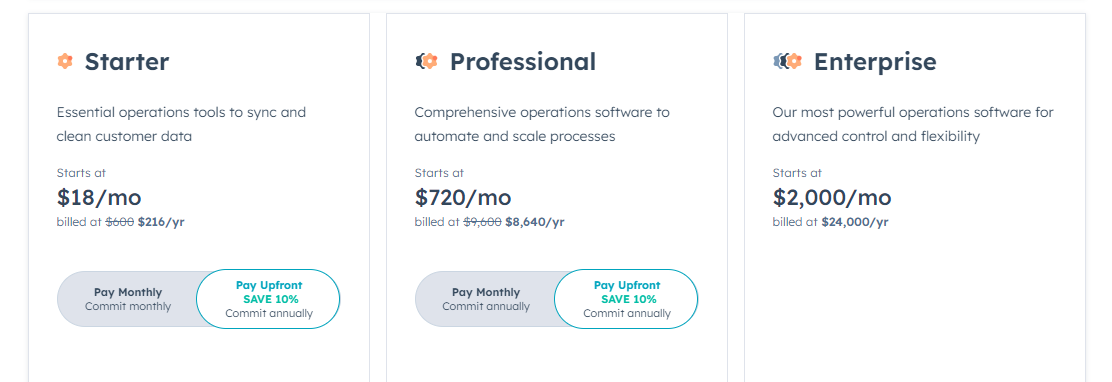

In [157]:
hscb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 274948 entries, 0 to 274947
Data columns (total 13 columns):
 #   Column                             Non-Null Count   Dtype    
---  ------                             --------------   -----    
 0   Customer ID                        274948 non-null  float64  
 1   Report Month                       274948 non-null  period[M]
 2   Customer Value Beginning of Month  274948 non-null  float64  
 3   Customer Value End of Month        274948 non-null  float64  
 4   Customer Cancellation Dollars      274948 non-null  float64  
 5   Customer Employee Size             274948 non-null  object   
 6   Product Tier                       274948 non-null  object   
 7   Customer Segment                   274948 non-null  object   
 8   Number of Integrations             274948 non-null  int64    
 9   Min Integrations                   274948 non-null  float64  
 10  Max Integrations                   274948 non-null  float64  
 11  Max Integrati

In [158]:
hscb.corr()

,Customer ID,Customer Value Beginning of Month,Customer Value End of Month,Customer Cancellation Dollars,Number of Integrations,Min Integrations,Max Integrations,Intergration Count Increase
Customer ID,1.000000,-0.107471,-0.100627,0.001507,-0.110877,-0.137937,-0.112443,-0.039607
Customer Value Beginning of Month,-0.107471,1.000000,0.968594,-0.070276,0.402892,0.383857,0.454723,0.360848
Customer Value End of Month,-0.100627,0.968594,1.000000,0.055829,0.395734,0.375731,0.458594,0.377064
Customer Cancellation Dollars,0.001507,-0.070276,0.055829,1.000000,0.000134,-0.012865,0.029723,0.067370
Number of Integrations,-0.110877,0.402892,0.395734,0.000134,1.000000,0.879078,0.869154,0.522025
Min Integrations,-0.137937,0.383857,0.375731,-0.012865,0.879078,1.000000,0.847138,0.343629
Max Integrations,-0.112443,0.454723,0.458594,0.029723,0.869154,0.847138,1.000000,0.790116
Intergration Count Increase,-0.039607,0.360848,0.377064,0.067370,0.522025,0.343629,0.790116,1.000000
